In [2]:
# from lensing_pointmass import *
import numpy as np
import matplotlib.pyplot as plt
import bilby
import scipy.constants as constants
from scipy.special import gamma, hyp1f1
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftfreq
import mpmath as mp
from lal import MTSUN_SI, PC_SI
from astropy.cosmology import FlatLambdaCDM
from chainconsumer import ChainConsumer, Chain, ChainConfig, PlotConfig
import matplotlib
plt.rcParams.update({'font.size': 15})
matplotlib.rcParams['text.usetex'] = True

# %config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/tmp/ipykernel_838454/3220566049.py:11: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import MTSUN_SI, PC_SI


In [3]:
#Amplification function
def laguerre(n,a,x):
    nplaguerre = np.frompyfunc(mp.laguerre,3,1)
    return nplaguerre(n,a,x)
vlaguerre = np.vectorize(laguerre)
def F_wave(fs,b):
    lague = np.array(vlaguerre(-0.5j*fs, 0, 0.5j*fs*b**2.),dtype='complex')
    ampl = np.power(-0.5j,1.+0.5j*fs)*np.power(fs,1.+0.5j*fs)*gamma(-0.5j*fs)*lague
    ampl[fs==0. + 0.j] = 1. #gamma of 0 is inf but F(0,b)=1.
    return ampl

#Geometric optics - multiple images
def t_delay_geom_plus(y):
    return (y**2. + 2. - y*np.sqrt(y**2 +4.))/4.-np.log(np.abs(y+np.sqrt(y**2+4.))/2.)
def t_delay_geom_minus(y):
    return (y**2 + 2. + y*np.sqrt(y**2 +4.))/4.-np.log(np.abs(y-np.sqrt(y**2+4.))/2.)
def DeltaT(y):
    return t_delay_geom_minus(y)-t_delay_geom_plus(y)

def mu_plus(y):
    return 0.5 + (y**2. + 2.)/(2.*y*np.sqrt(y**2 + 4.))
def mu_minus(y):
    return 0.5 - (y**2. + 2.)/(2.*y*np.sqrt(y**2 + 4.))

def F_geom_opt(ws,y):
    Fplus = np.sqrt(np.abs(mu_plus(y)))*np.exp(1.0j*ws*t_delay_geom_plus(y))
    Fminus = np.sqrt(np.abs(mu_minus(y)))*np.exp(1.0j*ws*t_delay_geom_minus(y))*np.exp(-1.0j*(np.pi/2.)*np.sign(ws))
    return Fplus + Fminus

def theta_plus(b):
    return 0.5*b*(1.+np.sqrt(1.+4./b**2.))
def theta_minus(b):
    return 0.5*b*(1.-np.sqrt(1.+4./b**2.))


In [4]:
ligo_psd = np.loadtxt('../data/AplusDesign.txt')
f_interp=ligo_psd[:,0]
ligo_interp = interp1d(f_interp,ligo_psd[:,1]**2)

virgo_psd = np.loadtxt('../data/V1_O5_strain.txt')
virgo_interp = interp1d(virgo_psd[:,0],virgo_psd[:,1]**2)

kagra_psd = np.loadtxt('../data/K1_O5_strain.txt')
kagra_interp = interp1d(kagra_psd[:,0],kagra_psd[:,1]**2)

In [71]:
yh = 0.5
zL = 0.5
zS = 0.8
H0 = 67.7
Om0 = 0.308
inc = np.pi/3
ML_GO = 1e11
ML = 1e4

m1 = 36*(1+zS)
m2 = 29*(1+zS)
Mc = (m1*m2)**(3/5)/(m1 + m2)**(1/5)
q = m2/m1

f_low = 10
delta_f = 1./1024
tc = 0
approx = 'IMRPhenomXPHM'

In [72]:
theta_plus(yh),theta_minus(yh)

(1.2807764064044151, -0.7807764064044151)

In [73]:
cosmo = FlatLambdaCDM(H0=H0,Om0=Om0)
DL = cosmo.angular_diameter_distance(zL).value
DS = cosmo.angular_diameter_distance(zS).value
DLS = cosmo.angular_diameter_distance_z1z2(zL,zS).value
print(DL,DS,DLS)

1298.2688497830052 1594.876641864513 512.9859337120085


In [74]:
xi0sq = 4*ML_GO*MTSUN_SI*constants.c/PC_SI *DL*DLS/DS*1e6
print(np.sqrt(xi0sq)) #pc

2827.2312672611174


In [75]:
thetaE = np.sqrt(4*ML_GO*MTSUN_SI*constants.c/PC_SI *DLS/DS/DL/1e6)
print(np.rad2deg(thetaE))
print(np.rad2deg(thetaE)*3600)

0.0001247726303751032
0.44918146935037156


In [76]:
dls = cosmo.luminosity_distance(zS).value
print(dls)

5167.400319641022


In [77]:
delta = 1e-3


In [78]:
duration = 1/delta_f
sampling_frequency = 4096

parameters = dict(mass_1=m1, mass_2=m2, a_1=0, a_2=0, tilt_1=0, tilt_2=0, luminosity_distance=dls, theta_jn=inc, geocent_time=tc, phase=0)

waveform_arguments = dict(waveform_approximant=approx,minimum_frequency=f_low)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

freq0 = waveform_generator.frequency_array

h = waveform_generator.frequency_domain_strain(parameters=parameters)


12:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [32]:
freq0

array([0.00000000e+00, 9.76562500e-04, 1.95312500e-03, ...,
       2.04799805e+03, 2.04799902e+03, 2.04800000e+03])

(10, 4240.4451280542835)

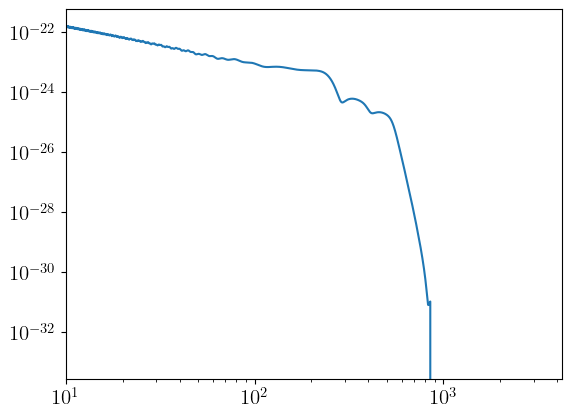

In [33]:
plt.loglog(freq0,np.abs(h['plus']+h['cross']))
plt.xlim(f_low)

In [34]:
w = 8*np.pi*ML_GO*(1+zL)*MTSUN_SI*freq0

F_0_GO = F_geom_opt(w,yh)
F_h_0_GO = (h['plus']+h['cross'])*np.conjugate(F_0_GO)

In [20]:
DeltaT(yh)*4*ML_GO*(1+zL)*MTSUN_SI, t_delay_geom_plus(yh)*4*ML_GO*(1+zL)*MTSUN_SI, t_delay_geom_minus(yh)*4*ML_GO*(1+zL)*MTSUN_SI

(430.38556122243716, -60.03981576051868, 370.34574546191845)

In [265]:
w = 8*np.pi*ML*(1+zL)*MTSUN_SI*freq0
F_0 = F_wave(w,yh)
F_h_0 = (h['plus']+h['cross'])*np.conjugate(F_0)

KeyboardInterrupt: 

/home/ansonchen/anaconda3/envs/gwsim_ac/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ansonchen/anaconda3/envs/gwsim_ac/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


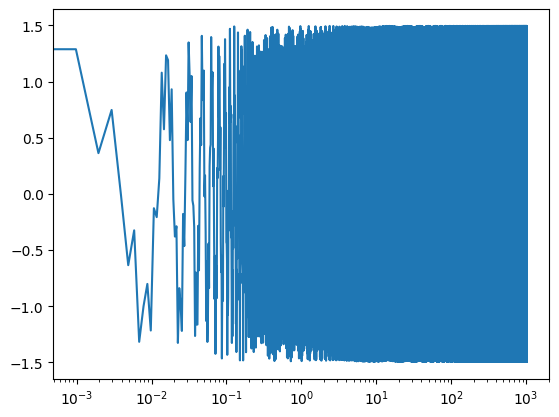

In [218]:
plt.semilogx(freq0,F_0_GO)

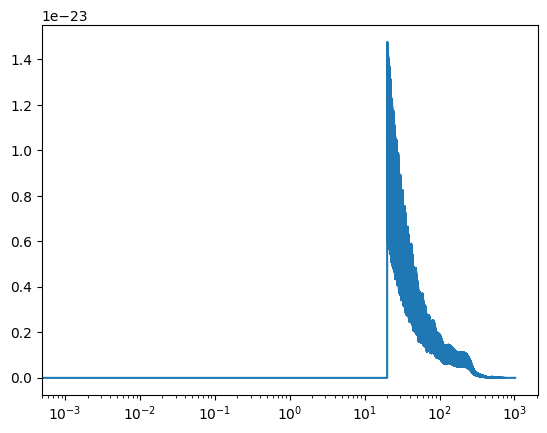

In [219]:
plt.semilogx(freq0,np.abs(F_h_0_GO))

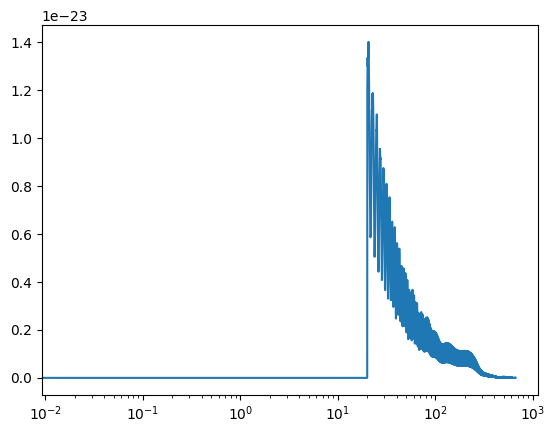

In [182]:
plt.semilogx(freq0,np.abs(F_h_0))

/home/ansonchen/anaconda3/envs/cross_correlate_gw/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ansonchen/anaconda3/envs/cross_correlate_gw/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


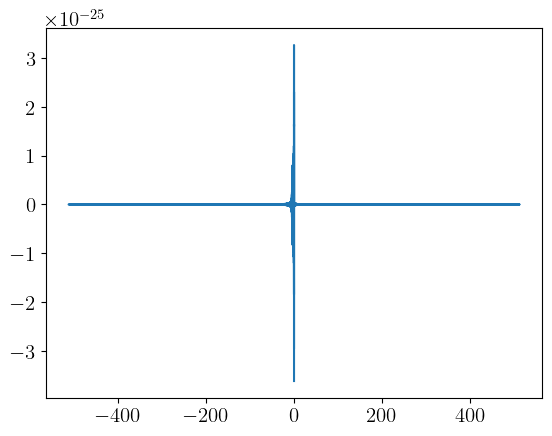

In [28]:
h_fft = ifft((h['plus']+h['cross']))
N = len(h_fft)

t_fft = fftfreq(N, delta_f)

fig=plt.figure()#(figsize=(8,2))
plt.plot(t_fft, h_fft)

/home/ansonchen/anaconda3/envs/cross_correlate_gw/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ansonchen/anaconda3/envs/cross_correlate_gw/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


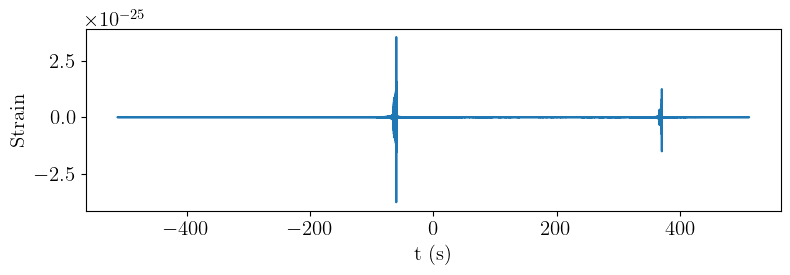

In [35]:
F_h_0_GO_fft = ifft(F_h_0_GO)
N = len(F_h_0_GO_fft)

t_fft = fftfreq(N, delta_f)

fig=plt.figure(figsize=(8,3))
plt.plot(t_fft, F_h_0_GO_fft)
plt.ylabel('Strain')
plt.xlabel('t (s)')
# plt.ylim(bottom=-1e-25)
# plt.xlim(-20,30)
fig.tight_layout()
# plt.savefig('../plots/Fisher_pm_GO_waveform.pdf')

In [36]:
t_delay_geom_plus(yh)*4*ML_GO*(1+zL)*MTSUN_SI, t_delay_geom_minus(yh)*4*ML_GO*(1+zL)*MTSUN_SI

(-60.03981576051868, 370.34574546191845)

/home/ansonchen/anaconda3/envs/cross_correlate_gw/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ansonchen/anaconda3/envs/cross_correlate_gw/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


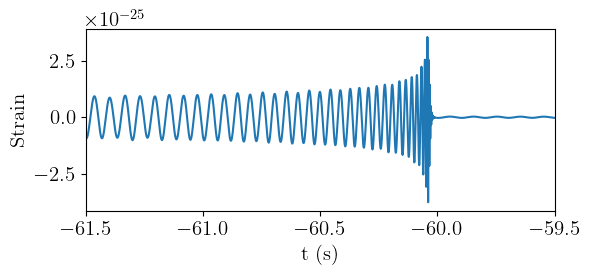

In [40]:
fig=plt.figure(figsize=(6,3))
plt.plot(t_fft[int(N/2+1):], F_h_0_GO_fft[int(N/2+1):])
plt.ylabel('Strain')
plt.xlabel('t (s)')
# plt.ylim(bottom=-1e-25)
plt.xlim(-61.5,-59.5)
fig.tight_layout()
plt.savefig('../plots/Fisher_pm_GO_waveform_plus.pdf')

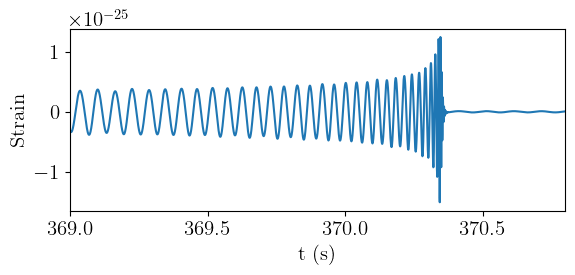

In [43]:
fig=plt.figure(figsize=(6,3))
plt.plot(t_fft[:int(N/2)], F_h_0_GO_fft[:int(N/2)])
plt.ylabel('Strain')
plt.xlabel('t (s)')
# plt.ylim(bottom=-1e-25)
plt.xlim(369,370.8)
fig.tight_layout()
plt.savefig('../plots/Fisher_pm_GO_waveform_minus.pdf')

In [44]:
DeltaT(yh)*4*1e4*(1+zL)*MTSUN_SI

0.43038556122243715

In [45]:
np.where(np.isnan(F_h_0)==True)

NameError: name 'F_h_0' is not defined

Text(0.5, 0, 't (s)')

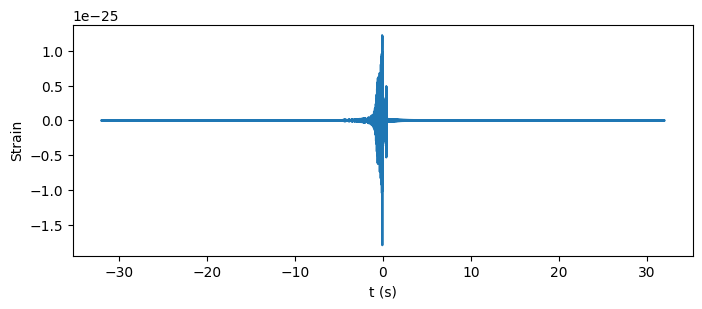

In [187]:
ind = np.where(np.isnan(F_h_0)==True)[0]
F_h_0_fft = ifft(F_h_0[:ind[0]])
N = len(F_h_0_fft)

t_fft = fftfreq(N, delta_f)

fig=plt.figure(figsize=(8,3))
plt.plot(t_fft, F_h_0_fft)
plt.ylabel('Strain')
plt.xlabel('t (s)')

Fisher matrix

In [79]:
def scalar_product(hf, gf, psd, freqs):
    return 2.*simps( np.real((hf*np.conjugate(gf)+np.conjugate(hf)*gf))/psd, x=freqs)

def Fisher_build(farr, psd, derivatives):

    Fisher_matrix = np.zeros((len(derivatives),len(derivatives)))

    for i in range(0, len(derivatives)):
        for j in range(0,i +1):
            Fisher_matrix[i,j] = scalar_product(derivatives[i], derivatives[j], psd, farr)
            Fisher_matrix[j,i] = Fisher_matrix[i,j]

    connum = np.linalg.cond(Fisher_matrix)
    print('condition number (div by 1e15)',connum/1.e15)

    return Fisher_matrix

In [80]:
ind = np.where(freq0>f_low)[0]
print(freq0[ind][0])

10.0009765625


In [91]:
ifos = bilby.gw.detector.InterferometerList(['L1','H1','V1','K1'])

ra = np.deg2rad(26)
dec = np.deg2rad(48)
print(ra,dec)

t_gps=30000
psi=0

0.4537856055185257 0.8377580409572782


In [92]:
h_det = []

for ifo in ifos:
    Fp = ifo.antenna_response(ra, dec, t_gps, psi, 'plus')
    Fx = ifo.antenna_response(ra, dec, t_gps, psi, 'cross')

    h_0 = Fp*h['plus']+Fx*h['cross']
    h_det.append(h_0)

snr_l1_sq = scalar_product(h_det[0][ind], h_det[0][ind], ligo_interp(freq0[ind]), freq0[ind])
snr_h1_sq = scalar_product(h_det[1][ind], h_det[1][ind], ligo_interp(freq0[ind]), freq0[ind])
snr_v1_sq = scalar_product(h_det[2][ind], h_det[2][ind], virgo_interp(freq0[ind]), freq0[ind])
snr_k1_sq = scalar_product(h_det[3][ind], h_det[3][ind], kagra_interp(freq0[ind]), freq0[ind])

snr = np.sqrt(snr_l1_sq+snr_h1_sq+snr_v1_sq+snr_k1_sq)
print(snr, np.sqrt(snr_l1_sq), np.sqrt(snr_h1_sq), np.sqrt(snr_v1_sq), np.sqrt(snr_k1_sq))

/tmp/ipykernel_838454/2320048601.py:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return 2.*simps( np.real((hf*np.conjugate(gf)+np.conjugate(hf)*gf))/psd, x=freqs)


11.20183860442464 4.446770760074905 7.862827437154624 4.685232261383835 4.683157191183912


In [93]:
mu_plus(yh), mu_minus(yh)

(1.5914103126634984, -0.5914103126634984)

In [94]:
np.sqrt(np.abs(mu_plus(yh))), np.sqrt(np.abs(mu_minus(yh)))

(1.2615111226871916, 0.7690320621817393)

In [95]:
snr*np.sqrt(np.abs(mu_minus(yh)))

8.614573042187697

In [96]:
snr*np.sqrt(np.abs(1-1/yh))

11.20183860442464

In [84]:
m1_dMc = ((1+q)/q**3)**(1./5)*(Mc+delta)
m2_dMc = (q**2*(1+q))**(1./5)*(Mc+delta)

In [85]:
parameters_dMc = dict(mass_1=m1_dMc, mass_2=m2_dMc, a_1=0, a_2=0, tilt_1=0, tilt_2=0, luminosity_distance=dls, theta_jn=inc, phase=0)

h_dMc = waveform_generator.frequency_domain_strain(parameters=parameters_dMc)

F_h_0_GO_dMc = (h_dMc['plus']+h_dMc['cross'])*np.conjugate(F_0_GO)

F_h_0_GO_Mc_deri = (F_h_0_GO_dMc[ind]-F_h_0_GO[ind])/delta

In [86]:
dq = q+delta
m1_dq = ((1+dq)/dq**3)**(1./5)*Mc
m2_dq = (dq**2*(1+dq))**(1./5)*Mc

In [87]:
parameters_dq = dict(mass_1=m1_dq, mass_2=m2_dq, a_1=0, a_2=0, tilt_1=0, tilt_2=0, luminosity_distance=dls, theta_jn=inc, phase=0)

h_dq = waveform_generator.frequency_domain_strain(parameters=parameters_dq)

F_h_0_GO_dq = (h_dq['plus']+h_dq['cross'])*np.conjugate(F_0_GO)

F_h_0_GO_q_deri = (F_h_0_GO_dq[ind]-F_h_0_GO[ind])/delta

In [88]:
parameters_ddl = dict(mass_1=m1, mass_2=m2, a_1=0, a_2=0, tilt_1=0, tilt_2=0, luminosity_distance=dls+delta, theta_jn=inc, phase=0)

h_ddl = waveform_generator.frequency_domain_strain(parameters=parameters_ddl)

F_h_0_GO_ddl = (h_ddl['plus']+h_ddl['cross'])*np.conjugate(F_0_GO)

F_h_0_GO_dl_deri = (F_h_0_GO_ddl[ind]-F_h_0_GO[ind])/delta

In [89]:
parameters_dinc = dict(mass_1=m1, mass_2=m2, a_1=0, a_2=0, tilt_1=0, tilt_2=0, luminosity_distance=dls, theta_jn=inc+delta, phase=0)

h_dinc = waveform_generator.frequency_domain_strain(parameters=parameters_dinc)

F_h_0_GO_dinc = (h_dinc['plus']+h_dinc['cross'])*np.conjugate(F_0_GO)

F_h_0_GO_inc_deri = (F_h_0_GO_dinc[ind]-F_h_0_GO[ind])/delta

In [90]:
F_h_0_GO_tc_deri = -1.j*2*np.pi*freq0[ind]* F_h_0_GO[ind]
F_h_0_GO_phic_deri = -1.j*F_h_0_GO[ind]

In [91]:
w_dML = 8*np.pi*(ML_GO+delta)*(1+zL)*MTSUN_SI*freq0

F_0_GO_dML = F_geom_opt(w_dML,yh)

F_h_0_GO_dML = (h['plus']+h['cross'])*np.conjugate(F_0_GO_dML)

F_h_0_GO_ML_deri = (F_h_0_GO_dML[ind]-F_h_0_GO[ind])/delta

In [92]:
F_0_GO_dy = F_geom_opt(w,yh+delta)

F_h_0_GO_dy = (h['plus']+h['cross'])*np.conjugate(F_0_GO_dy)

F_h_0_GO_y_deri = (F_h_0_GO_dy[ind]-F_h_0_GO[ind])/delta

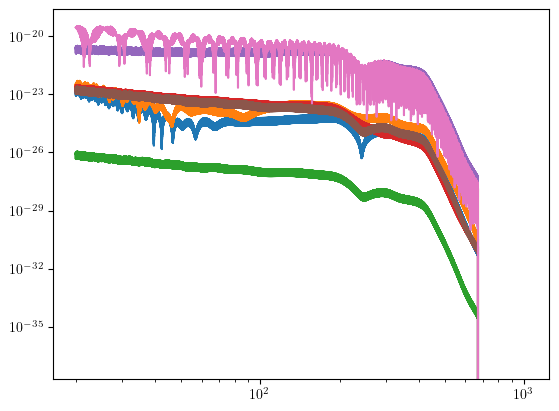

In [146]:
plt.loglog(freq0[ind],np.abs(F_h_0_GO_Mc_deri))
plt.loglog(freq0[ind],np.abs(F_h_0_GO_q_deri))
plt.loglog(freq0[ind],np.abs(F_h_0_GO_dl_deri))
plt.loglog(freq0[ind],np.abs(F_h_0_GO_inc_deri))
plt.loglog(freq0[ind],np.abs(F_h_0_GO_tc_deri))
plt.loglog(freq0[ind],np.abs(F_h_0_GO_phic_deri))
# plt.loglog(freq0[ind],np.abs(F_h_0_GO_ML_deri))
plt.loglog(freq0[ind],np.abs(F_h_0_GO_y_deri))

In [147]:
derivatives = [F_h_0_GO_Mc_deri,F_h_0_GO_q_deri,F_h_0_GO_dl_deri,F_h_0_GO_inc_deri,F_h_0_GO_tc_deri,F_h_0_GO_phic_deri]
derivatives_GO = [F_h_0_GO_Mc_deri,F_h_0_GO_q_deri,F_h_0_GO_dl_deri,F_h_0_GO_inc_deri,F_h_0_GO_tc_deri,F_h_0_GO_phic_deri,F_h_0_GO_y_deri]


In [95]:
fisher_list = []
for ifo in ifos:
    Fp = ifo.antenna_response(ra, dec, t_gps, psi, 'plus')
    Fx = ifo.antenna_response(ra, dec, t_gps, psi, 'cross')
    F_h_0_GO = (h['plus']*Fp+h['cross']*Fx)*np.conjugate(F_0_GO)

    F_h_0_GO_dMc = (h_dMc['plus']*Fp+h_dMc['cross']*Fx)*np.conjugate(F_0_GO)
    F_h_0_GO_Mc_deri = (F_h_0_GO_dMc[ind]-F_h_0_GO[ind])/delta

    F_h_0_GO_dq = (h_dq['plus']*Fp+h_dq['cross']*Fx)*np.conjugate(F_0_GO)
    F_h_0_GO_q_deri = (F_h_0_GO_dq[ind]-F_h_0_GO[ind])/delta

    F_h_0_GO_ddl = (h_ddl['plus']*Fp+h_ddl['cross']*Fx)*np.conjugate(F_0_GO)
    F_h_0_GO_dl_deri = (F_h_0_GO_ddl[ind]-F_h_0_GO[ind])/delta

    F_h_0_GO_dinc = (h_dinc['plus']*Fp+h_dinc['cross']*Fx)*np.conjugate(F_0_GO)
    F_h_0_GO_inc_deri = (F_h_0_GO_dinc[ind]-F_h_0_GO[ind])/delta

    F_h_0_GO_tc_deri = -1.j*2*np.pi*freq0[ind]* F_h_0_GO[ind]
    F_h_0_GO_phic_deri = -1.j*F_h_0_GO[ind]

    Fp_dra = ifo.antenna_response(ra+delta, dec, t_gps, psi, 'plus')
    Fx_dra = ifo.antenna_response(ra+delta, dec, t_gps, psi, 'cross')
    F_h_0_GO_dra = (h['plus']*Fp_dra+h['cross']*Fx_dra)*np.conjugate(F_0_GO)
    F_h_0_GO_ra_deri = (F_h_0_GO_dra[ind]-F_h_0_GO[ind])/delta

    Fp_ddec = ifo.antenna_response(ra, dec+delta, t_gps, psi, 'plus')
    Fx_ddec = ifo.antenna_response(ra, dec+delta, t_gps, psi, 'cross')
    F_h_0_GO_ddec = (h['plus']*Fp_ddec+h['cross']*Fx_ddec)*np.conjugate(F_0_GO)
    F_h_0_GO_dec_deri = (F_h_0_GO_ddec[ind]-F_h_0_GO[ind])/delta

    F_h_0_GO_dy = (h['plus']*Fp+h['cross']*Fx)*np.conjugate(F_0_GO_dy)
    F_h_0_GO_y_deri = (F_h_0_GO_dy[ind]-F_h_0_GO[ind])/delta

    derivatives_GO = [F_h_0_GO_Mc_deri,F_h_0_GO_q_deri,F_h_0_GO_dl_deri,F_h_0_GO_inc_deri,F_h_0_GO_tc_deri,F_h_0_GO_phic_deri,F_h_0_GO_ra_deri,F_h_0_GO_dec_deri,F_h_0_GO_y_deri]

    fisher_list.append(Fisher_build(freq0[ind], ligo_interp(freq0[ind]), derivatives_GO))

/tmp/ipykernel_313379/2320048601.py:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return 2.*simps( np.real((hf*np.conjugate(gf)+np.conjugate(hf)*gf))/psd, x=freqs)


condition number (div by 1e15) 17963324.720821023
condition number (div by 1e15) 10616691.952664696
condition number (div by 1e15) 54658071.344657
condition number (div by 1e15) 3211474.985090016


In [96]:
fisher_total = fisher_list[0]+fisher_list[1]+fisher_list[2]+fisher_list[3]

In [97]:
fisher_total

array([[ 1.42637720e+04, -1.74571579e+04, -9.18169070e-01,
        -1.27737989e+03,  3.41133065e+06, -1.27323310e+03,
        -1.78261819e+03,  9.99709155e+01, -6.97765800e+05],
       [-1.74571579e+04,  2.92410325e+04, -2.85842478e+00,
        -3.23045573e+03, -9.84113833e+06, -4.23620667e+03,
        -6.50720007e+03,  2.97202686e+02, -1.38826486e+06],
       [-9.18169070e-01, -2.85842478e+00,  8.32657585e-02,
         4.24693768e+01, -1.14768644e-09, -6.33160545e-12,
        -1.11829053e+01, -1.05106126e+01,  3.94428398e+04],
       [-1.27737989e+03, -3.23045573e+03,  4.24693768e+01,
         2.55794495e+04,  4.21112156e+06,  7.70243389e+03,
         6.52543298e+03, -5.99299277e+03,  2.02117132e+07],
       [ 3.41133065e+06, -9.84113833e+06, -1.14768644e-09,
         4.21112156e+06,  9.70132404e+09,  1.10923446e+07,
         1.74007980e+07,  1.44373499e+05,  4.23783115e+07],
       [-1.27323310e+03, -4.23620667e+03, -6.33160545e-12,
         7.70243389e+03,  1.10923446e+07,  1.883868

In [98]:
cov_matrix = np.linalg.inv(fisher_total)
pconstraints = np.sqrt(np.diag(cov_matrix))
print(pconstraints)

[2.01671915e-02 1.85880657e-02 2.23293559e+01 4.36275500e-02
 3.23808669e-05 3.45512588e-02 1.45148953e-02 1.24536058e-02
 7.29334715e-06]


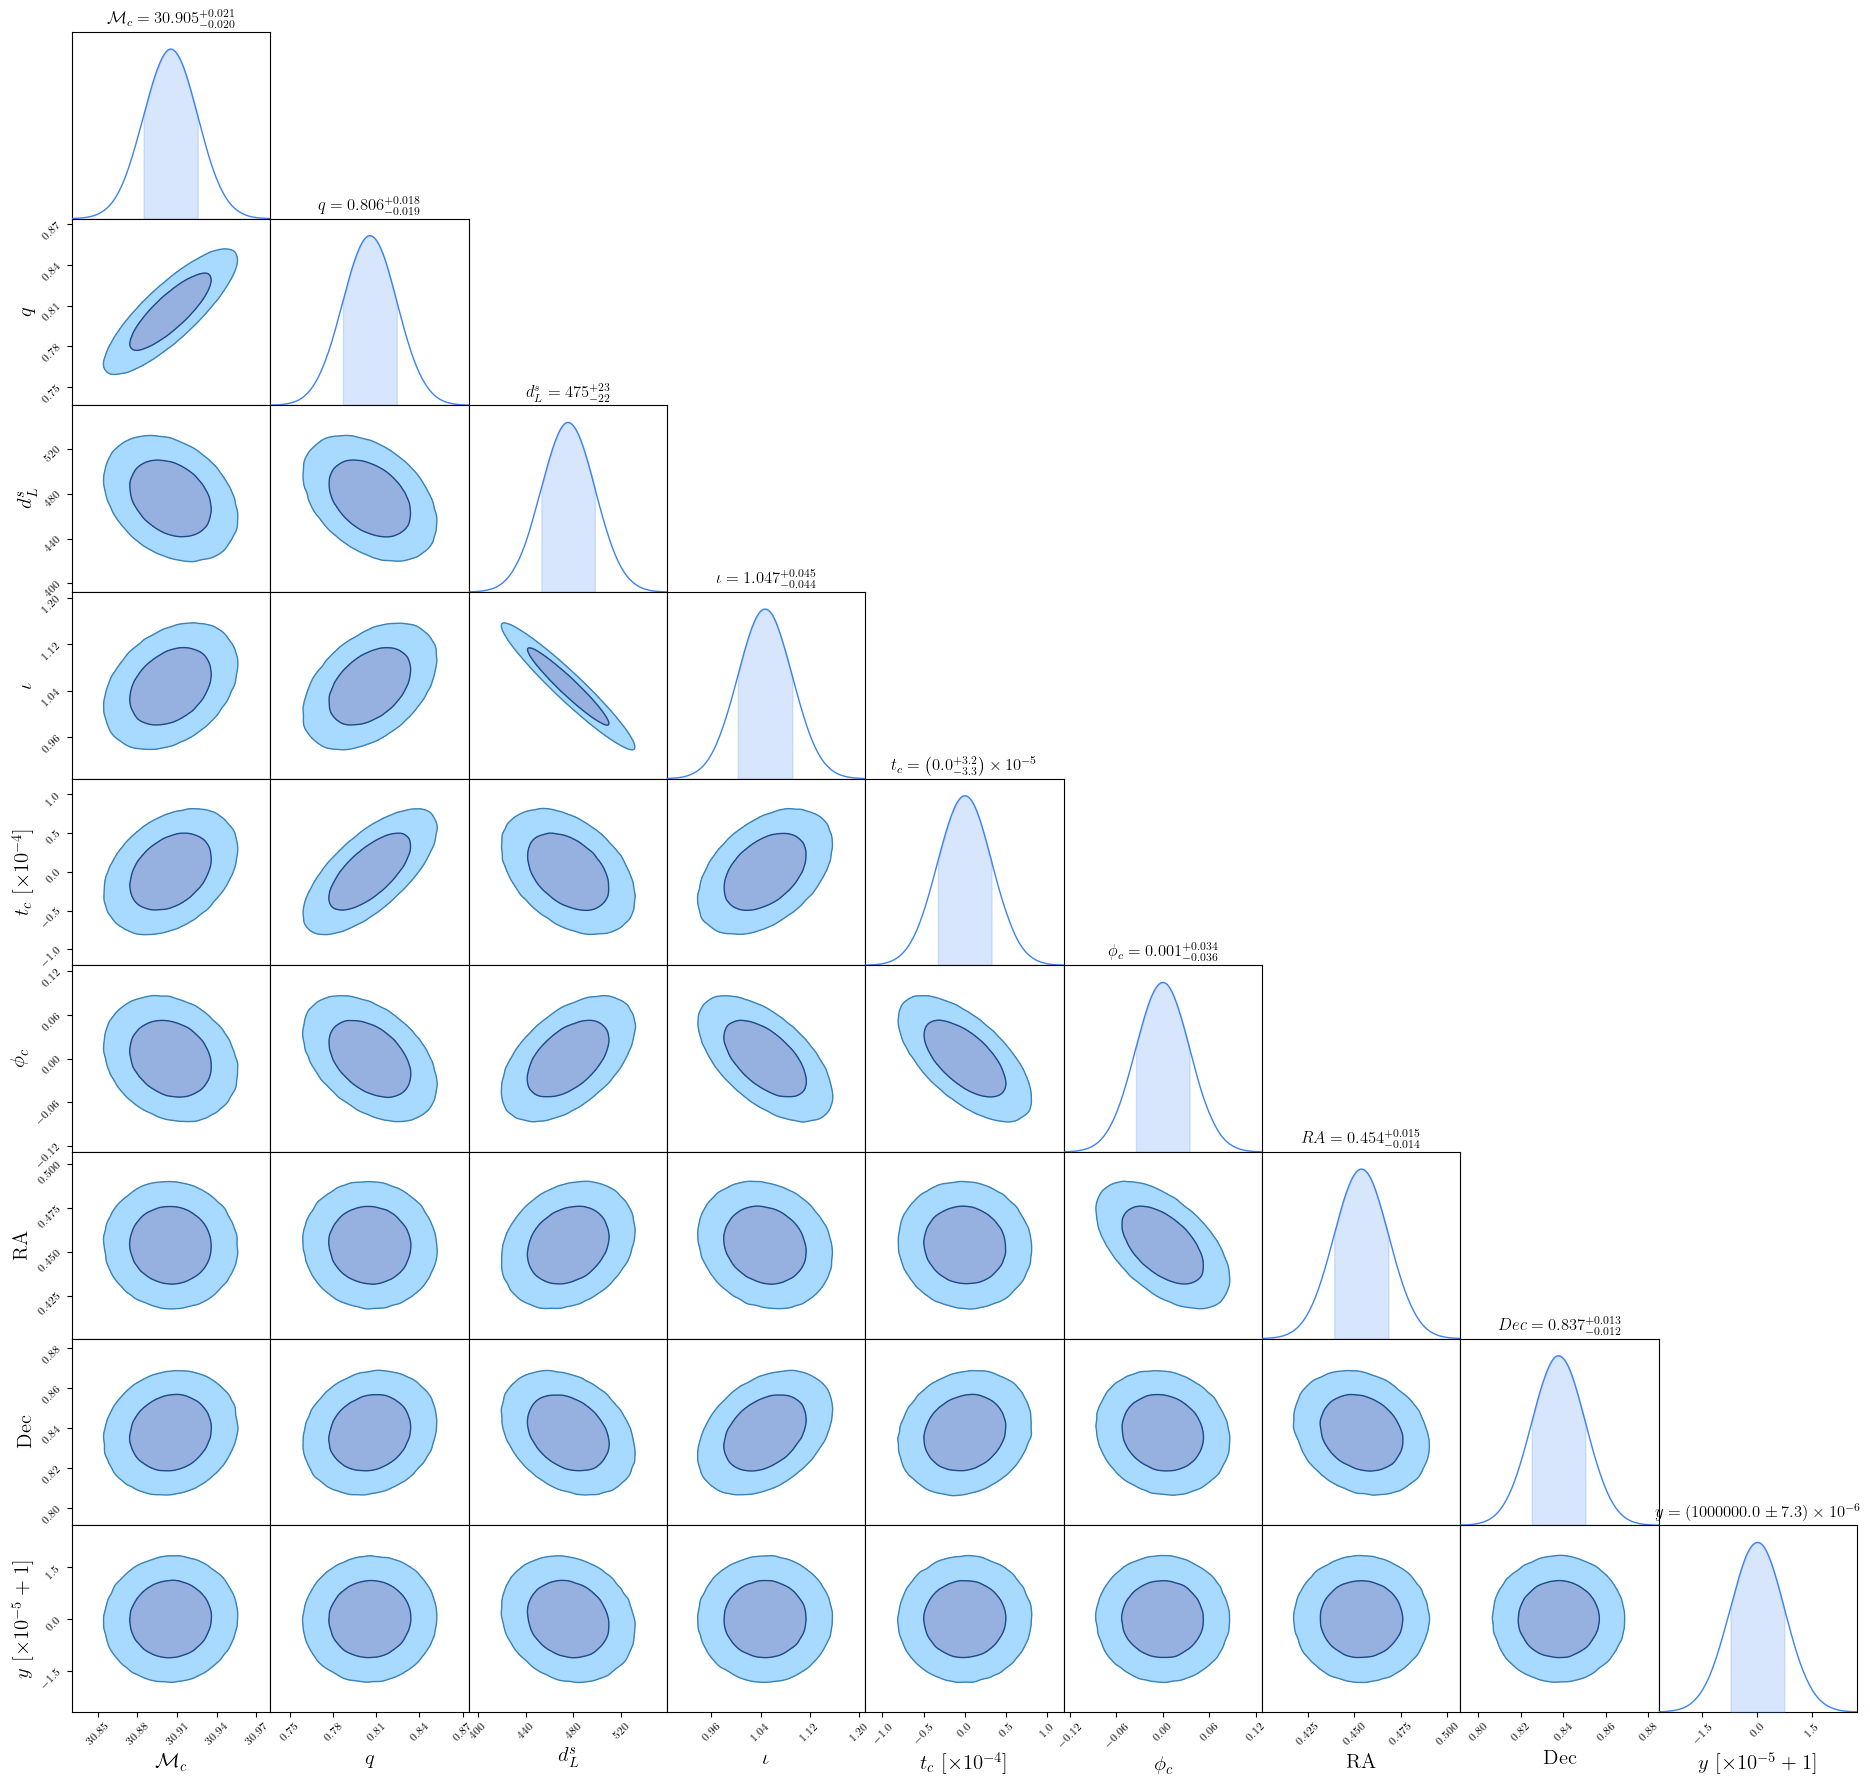

In [102]:
fid_val = [Mc,q,dls,inc,tc,0,ra,dec,yh]
label = [r'${\cal M}_c$',r'$q$',r'$d_L^s$',r'$\iota$',r'$t_c$',r'$\phi_c$',r'RA',r'Dec',r'$y$']

cc = ChainConsumer()
chain1 = Chain.from_covariance(fid_val,cov_matrix,columns=label,name='Fisher analysis')
cc.add_chain(chain1)
cc.set_override(ChainConfig(shade_alpha=0.5))
cc.set_plot_config(PlotConfig(spacing=0,serif=True,usetex=True,contour_label_font_size=15,label_font_size=15,tick_font_size=8))
cc.plotter.plot()
plt.savefig('../plots/Fisher_analysis_GO_new.pdf')

In [148]:
fisher_ligo = Fisher_build(freq0[ind], ligo_interp(freq0[ind]), derivatives)
fisher_virgo = Fisher_build(freq0[ind], virgo_interp(freq0[ind]), derivatives)
fisher_kagra = Fisher_build(freq0[ind], kagra_interp(freq0[ind]), derivatives)


/tmp/ipykernel_206520/2320048601.py:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return 2.*simps( np.real((hf*np.conjugate(gf)+np.conjugate(hf)*gf))/psd, x=freqs)


condition number (div by 1e15) 0.19392168955712363
condition number (div by 1e15) 0.1894595168931004
condition number (div by 1e15) 0.23104405191847496


In [149]:
fisher_ligo+fisher_virgo+fisher_kagra

array([[ 2.09087247e+02, -6.19317683e+02, -1.99900244e-02,
        -8.19494481e+01,  2.36434424e+05,  9.82794917e+01],
       [-6.19317683e+02,  2.45333782e+03, -3.42124376e-02,
         1.70072554e+02, -1.06512287e+06, -8.14596271e+02],
       [-1.99900244e-02, -3.42124376e-02,  4.68465332e-04,
         1.24804327e+00,  8.48966950e-11, -4.09174968e-13],
       [-8.19494481e+01,  1.70072554e+02,  1.24804327e+00,
         3.90185303e+03, -5.85524607e+05, -1.11540551e+03],
       [ 2.36434424e+05, -1.06512287e+06,  8.48966950e-11,
        -5.85524607e+05,  9.46428320e+08,  1.28114237e+06],
       [ 9.82794917e+01, -8.14596271e+02, -4.09174968e-13,
        -1.11540551e+03,  1.28114237e+06,  2.35241017e+03]])

In [150]:
cov_matrix = np.linalg.inv(fisher_ligo+fisher_virgo+fisher_kagra)
pconstraints = np.sqrt(np.diag(cov_matrix))
print(pconstraints)

[1.62532052e-01 6.00842157e-02 4.54129262e+02 1.71223786e-01
 1.25340850e-04 9.87596436e-02]


In [151]:
fisher_ligo_GO = Fisher_build(freq0[ind], ligo_interp(freq0[ind]), derivatives_GO)
fisher_virgo_GO = Fisher_build(freq0[ind], virgo_interp(freq0[ind]), derivatives_GO)
fisher_kagra_GO = Fisher_build(freq0[ind], kagra_interp(freq0[ind]), derivatives_GO)


/tmp/ipykernel_206520/2320048601.py:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return 2.*simps( np.real((hf*np.conjugate(gf)+np.conjugate(hf)*gf))/psd, x=freqs)


condition number (div by 1e15) 0.9312305433698221
condition number (div by 1e15) 1.0697241797332433
condition number (div by 1e15) 0.9879421856152402


In [152]:
fisher_ligo_GO+fisher_virgo_GO+fisher_kagra_GO

array([[ 2.09087247e+02, -6.19317683e+02, -1.99900244e-02,
        -8.19494481e+01,  2.36434424e+05,  9.82794917e+01,
        -6.05757907e+04],
       [-6.19317683e+02,  2.45333782e+03, -3.42124376e-02,
         1.70072554e+02, -1.06512287e+06, -8.14596271e+02,
        -9.97124851e+04],
       [-1.99900244e-02, -3.42124376e-02,  4.68465332e-04,
         1.24804327e+00,  8.48966950e-11, -4.09174968e-13,
         1.04057298e+03],
       [-8.19494481e+01,  1.70072554e+02,  1.24804327e+00,
         3.90185303e+03, -5.85524607e+05, -1.11540551e+03,
         2.76657014e+06],
       [ 2.36434424e+05, -1.06512287e+06,  8.48966950e-11,
        -5.85524607e+05,  9.46428320e+08,  1.28114237e+06,
         2.89463064e+06],
       [ 9.82794917e+01, -8.14596271e+02, -4.09174968e-13,
        -1.11540551e+03,  1.28114237e+06,  2.35241017e+03,
         1.29954026e+04],
       [-6.05757907e+04, -9.97124851e+04,  1.04057298e+03,
         2.76657014e+06,  2.89463064e+06,  1.29954026e+04,
         4.6623247

In [153]:
cov_matrix_GO = np.linalg.inv(fisher_ligo_GO+fisher_virgo_GO+fisher_kagra_GO)
pconstraints_GO = np.sqrt(np.diag(cov_matrix_GO))
print(pconstraints_GO)

[1.62926429e-01 6.02157126e-02 4.57953738e+02 1.71303214e-01
 1.25349760e-04 9.87900022e-02 2.06818639e-05]


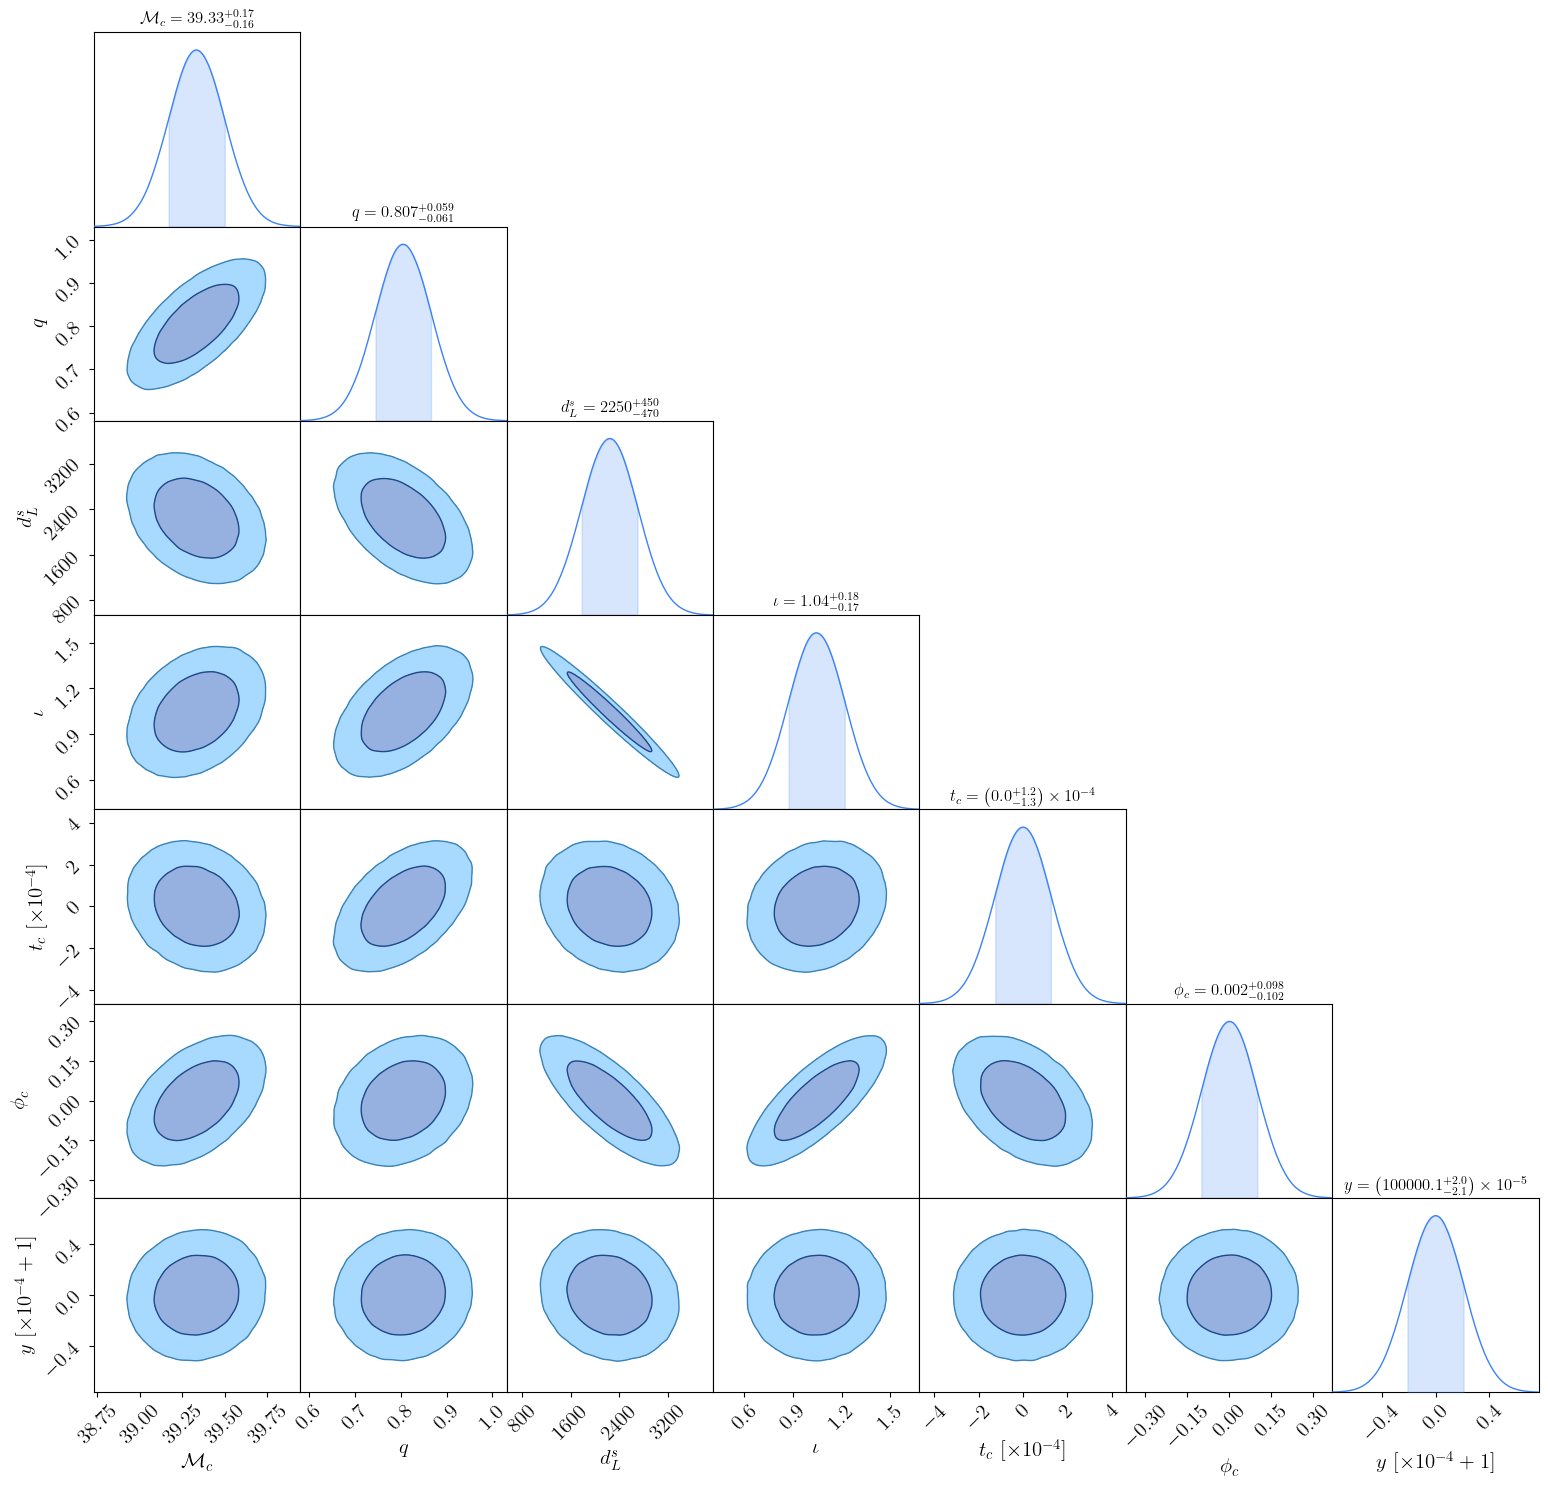

In [156]:
fid_val = [Mc,q,dls,inc,tc,0,yh]
label = [r'${\cal M}_c$',r'$q$',r'$d_L^s$',r'$\iota$',r'$t_c$',r'$\phi_c$',r'$y$']

cc = ChainConsumer()
chain1 = Chain.from_covariance(fid_val,cov_matrix_GO,columns=label,name='Fisher analysis')
cc.add_chain(chain1)
cc.set_override(ChainConfig(shade_alpha=0.5))
cc.set_plot_config(PlotConfig(spacing=0,serif=True,usetex=True,contour_label_font_size=15,label_font_size=15,tick_font_size=15))
cc.plotter.plot()
plt.savefig('../plots/Fisher_analysis_GO.pdf')